In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import h5py
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
image_files = Path('../input/food41/images')
images = list(image_files.glob(r'**/*.jpg'))
label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], images))
imagedata = pd.DataFrame({'Files' : images, "label" : label}).astype(str).sample(frac = 1.0, random_state = 1).reset_index(drop=True)

category_samples = []
for category in imagedata['label'].unique():
    category_slice = imagedata.query('label== @category')
    category_samples.append(category_slice.sample(750, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state =1).reset_index(drop=True)

In [3]:
image_df

,Files,label
0,../input/food41/images/garlic_bread/2643891.jpg,garlic_bread
1,../input/food41/images/gyoza/118226.jpg,gyoza
2,../input/food41/images/foie_gras/1335868.jpg,foie_gras
3,../input/food41/images/tiramisu/1119464.jpg,tiramisu
4,../input/food41/images/frozen_yogurt/2449858.jpg,frozen_yogurt
...,...,...
75745,../input/food41/images/paella/440387.jpg,paella
75746,../input/food41/images/apple_pie/3252424.jpg,apple_pie
75747,../input/food41/images/frozen_yogurt/2642393.jpg,frozen_yogurt
75748,../input/food41/images/croque_madame/3288700.jpg,croque_madame


In [4]:
image_df['label'].value_counts()

oysters                 750
pork_chop               750
chicken_quesadilla      750
beignets                750
lobster_bisque          750
                       ... 
macarons                750
spaghetti_carbonara     750
pulled_pork_sandwich    750
donuts                  750
club_sandwich           750
Name: label, Length: 101, dtype: int64

In [5]:
image_df['label']

0         garlic_bread
1                gyoza
2            foie_gras
3             tiramisu
4        frozen_yogurt
             ...      
75745           paella
75746        apple_pie
75747    frozen_yogurt
75748    croque_madame
75749       beet_salad
Name: label, Length: 75750, dtype: object

In [6]:
traindata, testdata = train_test_split(image_df, train_size =0.75, random_state =1)

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input, validation_split=0.2)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=traindata,
    x_col='Files',
    y_col='label',
    target=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=True,
    subset ='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=traindata,
    x_col='Files',
    y_col='label',
    target=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=True,
    subset ='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=testdata,
    x_col='Files',
    y_col='label',
    target=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 45450 validated image filenames belonging to 101 classes.
Found 11362 validated image filenames belonging to 101 classes.
Found 18938 validated image filenames belonging to 101 classes.


In [9]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling = 'avg'        
) 

base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 101)               2

In [11]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1)
early_stop = EarlyStopping(monitor = 'val_accuracy',patience = 3,restore_best_weights = True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [12]:
history = model.fit(train_images, 
                    epochs=15,
                    validation_data = val_images,
                    callbacks=[early_stop, reduce_lr, model_checkpoint_callback])

Epoch 1/15
1421/1421 [==============================] - 762s 532ms/step - loss: 3.0755 - accuracy: 0.2782 - val_loss: 1.9344 - val_accuracy: 0.5062
Epoch 2/15
1421/1421 [==============================] - 342s 241ms/step - loss: 1.9178 - accuracy: 0.5039 - val_loss: 1.8076 - val_accuracy: 0.5369
Epoch 3/15
1421/1421 [==============================] - 346s 243ms/step - loss: 1.6687 - accuracy: 0.5620 - val_loss: 1.7207 - val_accuracy: 0.5536
Epoch 4/15
1421/1421 [==============================] - 350s 246ms/step - loss: 1.5125 - accuracy: 0.5998 - val_loss: 1.7067 - val_accuracy: 0.5613
Epoch 5/15
1421/1421 [==============================] - 348s 245ms/step - loss: 1.3655 - accuracy: 0.6312 - val_loss: 1.7374 - val_accuracy: 0.5592
Epoch 6/15
1421/1421 [==============================] - 347s 244ms/step - loss: 1.1026 - accuracy: 0.6944 - val_loss: 1.6179 - val_accuracy: 0.5955
Epoch 7/15
1421/1421 [==============================] - 345s 243ms/step - loss: 0.9643 - accuracy: 0.7292 - val_

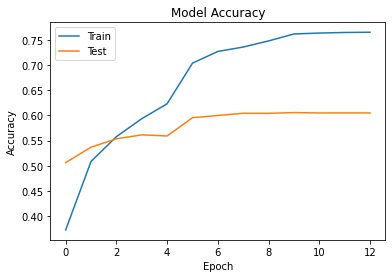

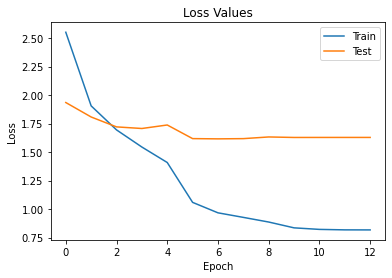

In [13]:
#Plotting Accuracy v/s Epochs
plt.figure(1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
#Plotting Loss v/s Epochs
plt.figure(2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Values')

plt.show()